In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('model-interpretation-and-explanation')
jovian.set_colab_id('1wP8H-BvNu68Fw4CeQziaHXuYkVrv_DyD')

<a id='top'></a>
## Table of Contents
1. [Models implementation and evaluation](#mid-term2)
    1. [Implementation](#impl-midterm2)
    2. [Experiments](#exp)
    3. [Conclusion](#conc-midterm2)
2. [Interpret GradientBoostingRegressor model](#igm-gbr)
    1. [Global Interpretability](#gi-gbr)
        1. [Variable Importance Plot](#vip-gbr)
        2. [SHAP Dependence Plot](#sdp-gbr)
    2. [Local Interpretability](#li-gbr)
        1. [Heatmap plot](#hp-gbr)
        2. [Test Case 1](#tc1-gbr)
            1. [Individual SHAP Value Plot](#isvp-gbr_1)
            2. [Waterfall plot](#wp-gbr_1)
            3. [Individual bar plot](#ibp-gbr_1)
            4. [Decision plot](#dp-gbr_1)
        2. [Test Case 2](#tc2-gbr)
            1. [Individual SHAP Value Plot](#isvp-gbr_2)
            2. [Waterfall plot](#wp-gbr_2)
            3. [Individual bar plot](#ibp-gbr_2)
            4. [Decision plot](#dp-gbr_2)
        3. [Test Case 3](#tc3-gbr)
            1. [Individual SHAP Value Plot](#isvp-gbr_3)
            2. [Waterfall plot](#wp-gbr_3)
            3. [Individual bar plot](#ibp-gbr_3)
            4. [Decision plot](#dp-gbr_3)
3. [Interpret StackingClassifier model](#igm-stc)
    1. [Global Interpretability](#gi-stc)
    2. [Local Interpretability](#li-stc)
        1. [Test Case 1](#tc1-stc)
        2. [Test Case 2](#tc2-stc)
    3. [Diverse Counterfactual Explanations](#dice-stc)
        1. [Test Case 1](#tc1-dice-stc)
        2. [Test Case 2](#tc2-dice-stc)
    3. [Association rule mining](#arm-stc)
        1. [Top rules](#tr-stc)
        2. [Rules related to correct and incorrect predition](#rrtcp-stc)
        3. [Rules related to the cooperation](#rrttc-stc)
        4. [Conclusion](#conc-ar)
4. [Conclusion](#conc)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='mid-term2'></a>
# Models implementation and evaluation ([to top](#top))

<a id='impl-midterm2'></a>
## Implementation ([to top](#top))

Regarding the suggestion of model implementation, we dropped the features ('**popularity**', '**vote_average**', '**vote_count**') that are still not available before a movie is released. Then, we redid the features engineering, data preprocessing and retrained all the models for regression and classification tasks.

Notebook for the model implementation **with** the features 'popularity', 'vote_average', 'vote_count' :

[post-analysis-models-implementation-and-evaluation](https://jovian.ai/lilanpei/post-analysis-models-implementation-and-evaluation)

Notebook for  the model implementation **without** the features 'popularity', 'vote_average', 'vote_count' : 

[pre-analysis-models-implementation-and-evaluation](https://jovian.ai/lilanpei/pre-analysis-models-implementation-and-evaluation)

<a id='exp'></a>
## Experiments ([to top](#top))

In [3]:
from IPython.display import display, HTML
from joblib import dump, load
import tabulate

The table below shows that the **gradient boosting** model achieved the best performance of **post-prediction** and **pre-prediction** for **regression** tasks. Still, the **R2 score** decreased from **0.48** to **0.34**, mainly because '**vote_count**' has the top spot in the feature importance.

In [4]:
# performance for post-prediction
regressor_table_post = load('/content/drive/MyDrive/BDA/models/regressor_table_post.joblib')
display(HTML(tabulate.tabulate(regressor_table_post, tablefmt='html', headers=["Model", "RMSE", "MAE", "R2", "PEARSONR"])))

Model,RMSE,MAE,R2,PEARSONR
Dummy,2.5134,1.731,-0.0002,nan
DecisionTree,1.9908,1.3494,0.3725,0.6108
DecisionTree Bagging,1.9465,1.2985,0.4001,0.6534
RandomForest,1.8107,1.2238,0.4809,0.6973
GradientBoosting,1.8106,1.2204,0.4809,0.6984
Multi-layer Perceptron,2.2101,1.394,0.2266,0.4783
MLP Bagging,2.2739,1.4486,0.2266,0.4305
AutoSklearn,1.8356,1.2148,0.4666,0.6872


In [5]:
# performance for pre-prediction
regressor_table_pre = load('/content/drive/MyDrive/BDA/models/regressor_table_pre.joblib')
display(HTML(tabulate.tabulate(regressor_table_pre, tablefmt='html', headers=["Model", "RMSE", "MAE", "R2", "PEARSONR"])))

Model,RMSE,MAE,R2,PEARSONR
Dummy,2.5134,1.731,-0.0002,nan
DecisionTree,2.1078,1.4931,0.2966,0.5458
DecisionTree Bagging,2.0974,1.4595,0.3035,0.5651
RandomForest,2.0376,1.434,0.3427,0.5875
GradientBoosting,2.0356,1.4248,0.344,0.5939
Multi-layer Perceptron,2.3829,1.5704,0.101,0.3272
MLP Bagging,2.3789,1.5577,0.101,0.3297
AutoSklearn,2.14,1.4711,0.275,0.5419


The table below shows that the **stacking classifier**  achieved the best performance of **post-prediction** and **pre-prediction** for **classification** tasks. Still, the **ROC AUC score** decreased from **79.48%** to **71.01%**, also because 'vote_count' has the top spot in the feature importance. 

In [6]:
# performance for post-prediction
classifier_table_post = load('/content/drive/MyDrive/BDA/models/classifier_table_post.joblib')
display(HTML(tabulate.tabulate(classifier_table_post, tablefmt='html', headers=["Accuracy", "Precision", "Recall", "F-score", "ROC-AUC"])))

,Accuracy,Precision,Recall,F-score,ROC-AUC
Dummy,44.67%,22.34%,50.00%,30.88%,50.00%
DecisionTree,75.11%,74.98%,75.24%,75.00%,75.24%
DecisionTree Bagging,77.24%,77.28%,77.59%,77.18%,77.59%
RandomForest,77.73%,77.56%,77.82%,77.61%,77.82%
GradientBossting,78.73%,78.53%,78.79%,78.60%,78.79%
Multi-layer Perceptron,75.84%,75.95%,76.23%,75.79%,76.23%
MLP Bagging,75.93%,75.95%,76.25%,75.86%,76.25%
MLP-SVM,76.74%,76.56%,76.81%,76.61%,76.81%
StackingClassifier,79.45%,79.24%,79.48%,79.31%,79.48%
AutoSklearn,77.42%,77.16%,77.28%,77.21%,77.28%


In [7]:
# performance for pre-prediction
classifier_table_pre = load('/content/drive/MyDrive/BDA/models/classifier_table_pre.joblib')
display(HTML(tabulate.tabulate(classifier_table_pre, tablefmt='html', headers=["Accuracy", "Precision", "Recall", "F-score", "ROC-AUC"])))

,Accuracy,Precision,Recall,F-score,ROC-AUC
Dummy,44.67%,22.34%,50.00%,30.88%,50.00%
DecisionTree,68.34%,68.28%,68.49%,68.23%,68.49%
DecisionTree Bagging,69.60%,69.36%,69.51%,69.39%,69.51%
RandomForest,69.87%,69.60%,69.73%,69.64%,69.73%
GradientBossting,70.23%,69.91%,69.98%,69.94%,69.98%
Multi-layer Perceptron,67.48%,67.86%,68.00%,67.46%,68.00%
MLP Bagging,67.57%,67.98%,68.11%,67.55%,68.11%
MLP-SVM,68.02%,67.79%,67.94%,67.81%,67.94%
StackingClassifier,71.18%,70.90%,71.01%,70.94%,71.01%
AutoSklearn,70.01%,69.84%,70.04%,69.86%,70.04%


<a id='conc-midterm2'></a>
## Conclusion ([to top](#top))

1. We used different ways to **encode the text features**. Such as mapping **month** onto a circle since it is a cyclical variable, creating binary variables for different **genres** and **production_countries**, and segmenting  **production_companies**, **writer**, **director**, and **actors** into clusters by **RFM** (Recency - Frequency - Monetary) model.

2. We also performed an **oversampling** strategy to address the imbalance of the dataset, and **Min-Max normalization** was used as data pre-processing for the NN-related models.

3. We trained different models to solve the movies profitability **regression** and **classification** tasks, such as **decision tree**, **random forest**, **multilayer perceptron**, **gradient boosting**, and **MLP-quasi-SVM**. We also tried to **ensemble** manually different models to achieve the best performances by **bagging** and **stacking** approaches. The **dummy classifier** and an **auto-ml** approach were used as the **baseline** and **benchmark**.

4. From the sections of the **experiments**, we can see the **Tree-based** approaches achieved better performance than the **NN-based** models since our dataset is more like a tabular dataset. As we expected, the **ensemble** method always gives us better results than an individual model.

<a id='igm-gbr'></a>
# Interpret GradientBoostingRegressor model ([to top](#top))

Install the SHAP library

In [8]:
!pip3 install shap

In [9]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
import random
import warnings
from pathlib import Path
from sklearn.inspection import permutation_importance
import shap
import os
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

random.seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore")

Load the dataset and the GradientBoostingRegressor model we trained in the previous task.

In [10]:
df = pd.read_csv('/content/drive/MyDrive/BDA/input/return_df_pre.csv', keep_default_na=False)
return_df = df[df.columns.difference(['popularity', 'vote_average', 'vote_count'])]
X, y = return_df.drop(['revenue', 'return', 'return_log'], axis=1), return_df['return_log']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
gbr_rfe_support = np.load('/content/drive/MyDrive/BDA/models/gbr_rfe_support.npy')
train_X, test_X = train_X.loc[:, gbr_rfe_support], test_X.loc[:, gbr_rfe_support]
eda_df = pd.read_csv('/content/drive/MyDrive/BDA/input/eda_df.csv') #we need this dataset to show the features encode with clustering

gbr = load('/content/drive/MyDrive/BDA/models/GradientBoostingRegressor.joblib')

In [11]:
test_predictions = gbr.predict(test_X)
gbr_results = {
    "RMSE" : np.sqrt(mean_squared_error(test_y, test_predictions)),
    "MAE" : mean_absolute_error(test_y, test_predictions),
    "R2" : gbr.score(test_X, test_y),
    "PEARSONR" : pearsonr(test_y.values, test_predictions)[0]
}
print("Test RMSE : {:.4f}".format(gbr_results['RMSE']))
print("Test MAE : {:.4f}".format(gbr_results['MAE']))
print("Test R2 : {:.4f}".format(gbr_results['R2']))
print("Test PEARSONR : {:.4f}".format(gbr_results['PEARSONR']))

Test RMSE : 2.0356
Test MAE : 1.4248
Test R2 : 0.3440
Test PEARSONR : 0.5939


<a id='gi-gbr'></a>
## Global Interpretability ([to top](#top))

In [12]:
if not Path('/content/drive/MyDrive/BDA/img/gbr_permutation_importance.png').is_file():
  # Create path if it doesn't exist yet
  path = "/content/drive/MyDrive/BDA/img/"
  os.makedirs(path, exist_ok=True)
  feature_importance = gbr.feature_importances_
  sorted_idx = np.argsort(feature_importance)
  pos = np.arange(sorted_idx.shape[0]) + 0.5
  fig = plt.figure(figsize=(15, 8))
  plt.subplot(1, 2, 1)
  plt.barh(pos, feature_importance[sorted_idx], align="center")
  plt.yticks(pos, np.array(test_X.columns)[sorted_idx])
  plt.title("Feature Importance (GBR)")

  result = permutation_importance(
      gbr, test_X, test_y, n_repeats=10, random_state=42, n_jobs=2
  )
  sorted_idx = result.importances_mean.argsort()
  plt.subplot(1, 2, 2)
  plt.boxplot(
      result.importances[sorted_idx].T,
      vert=False,
      labels=np.array(test_X.columns)[sorted_idx],
  )
  plt.title("Permutation Importance (Test set)")
  fig.tight_layout()
  plt.savefig('/content/drive/MyDrive/BDA/img/gbr_permutation_importance.png', format='png')
  plt.show()
  plt.close()

<img src = 'https://drive.google.com/uc?id=105zmXe1oXwCa0ikMjNwO8KBwfIx3QkPH'>

This is the Feature Importance provided by Gradient Boosting itself and by sklearn Permutation Importance. You will spot later that there are some differences between SHAP and these methods. This is due to the different approaches of the three methods: 
* Gradient Boosting, for each tree, calculates the fraction of samples that will traverse a splitting node based on each feature. Then, it average those numbers across all trees. 
* Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature’s values. 
* SHAP requires to train a distinct predictive model for each distinct combination of variables, weighting features based on the goodness of the results.

<a id='vip-gbr'></a>
### Variable Importance Plot ([to top](#top))

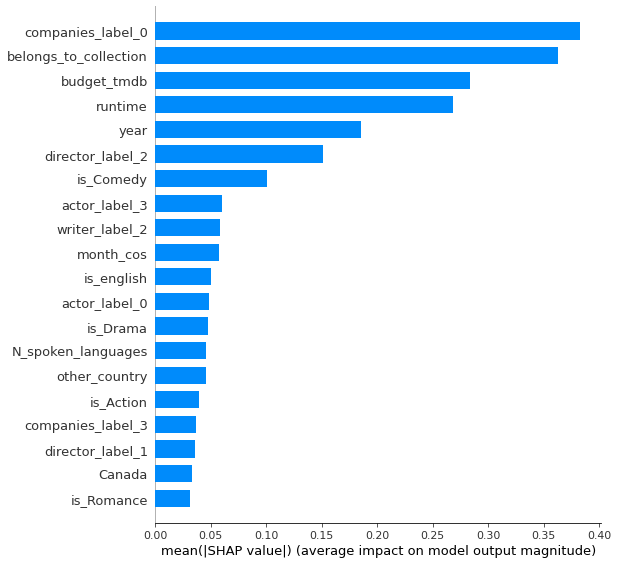

In [13]:
if (Path('/content/drive/MyDrive/BDA/models/gbr_explainer.joblib').is_file() &
    Path('/content/drive/MyDrive/BDA/models/gbr_shap_values.joblib').is_file()):
  gbr_explainer = load('/content/drive/MyDrive/BDA/models/gbr_explainer.joblib')
  gbr_shap_values = load('/content/drive/MyDrive/BDA/models/gbr_shap_values.joblib')
else:
  gbr_explainer = shap.TreeExplainer(gbr)
  gbr_shap_values = gbr_explainer.shap_values(train_X)
  dump(gbr_explainer, '/content/drive/MyDrive/BDA/models/gbr_explainer.joblib')
  dump(gbr_shap_values, '/content/drive/MyDrive/BDA/models/gbr_shap_values.joblib')

shap.summary_plot(gbr_shap_values, train_X, plot_type="bar")

As mentioned before, the ranking provided by SHAP is different, but the top 5 remains the same with a different order.

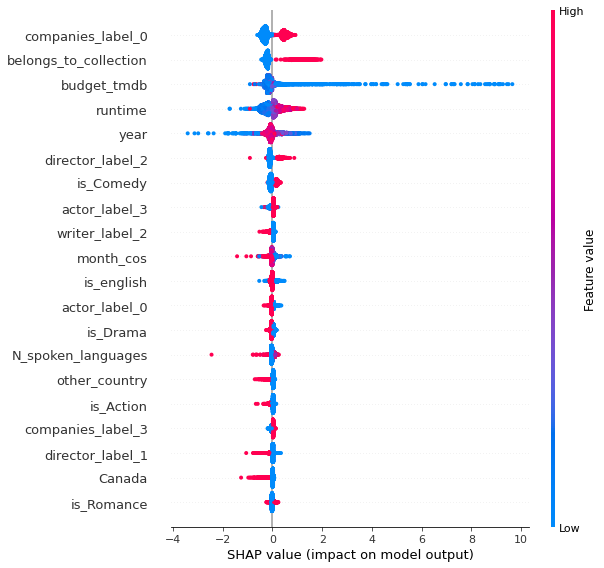

In [14]:
shap.summary_plot(gbr_shap_values, train_X)

The SHAP value plot can show the positive (in red) and negative (in blue) relationships of the predictors with the target variable. The horizontal location shows whether the effect of that value is associated with a higher or lower prediction. As you can see, being in 0 cluster of companies has a high and positive impact on the quality rating. As well as belonging to a collection or runtime. In this way it is possible to investigate the correlation between the traget and the features. 

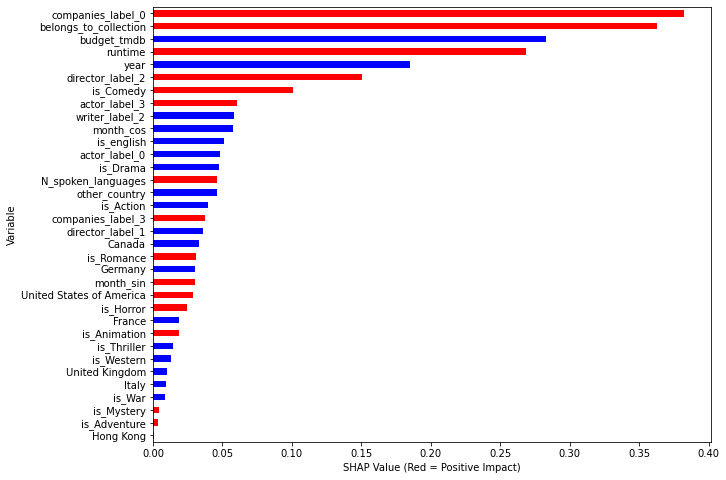

In [15]:
def simple_SHAP(df_shap, df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable', how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,8),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
simple_SHAP(gbr_shap_values, train_X) 

This is a simplified version of the summary plot with only the predominant impact.

<a id='sdp-gbr'></a>
### SHAP Dependence Plot ([to top](#top))

Wtih the partial dependence plot we can investigate the marginal effect that a feature has on the predicted outcome of our model.

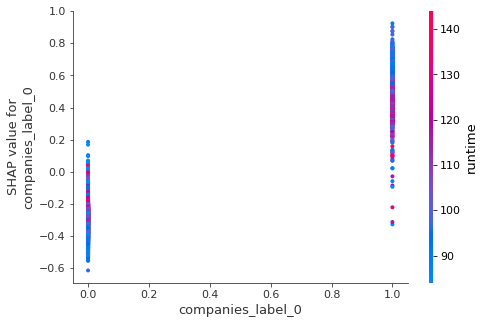

In [16]:
shap.dependence_plot("companies_label_0", gbr_shap_values, train_X)

For this feature, being it binary, it is hard to spot the correlation found in the previous plot. Obviously this is a variable produced by a cluster, and to be really explanatory let's see what differentiates the clusters.

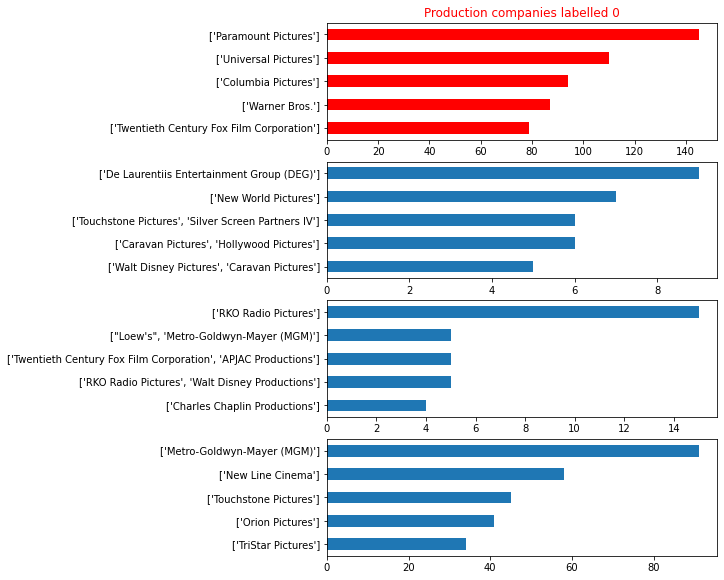

In [17]:
# using subplot function and creating 3 plots
plt.subplot(4, 1, 1)  #count 1
comp0=eda_df[df['companies_label_0']==1]
comp0['production_companies'].value_counts().head().plot.barh(color='r',figsize=(10,8))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.title('Production companies labelled 0',color='r')

plt.subplot(4, 1, 2) #count2
comp1=eda_df[df['companies_label_1']==1]
comp1['production_companies'].value_counts().head().plot.barh(figsize=(10,8))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
#plt.title('Production companies labelled 1')
 

plt.subplot(4, 1, 3) #count3
comp2=eda_df[df['companies_label_2']==1]
comp2['production_companies'].value_counts().head().plot.barh(figsize=(10,8))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
#plt.title('Production companies labelled 2')

plt.subplot(4, 1, 4) #count3
comp3=eda_df[df['companies_label_3']==1]
comp3['production_companies'].value_counts().head().plot.barh(figsize=(10,8))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
#plt.title('Production companies labelled 3')

# space between the plots
plt.tight_layout(0.5)
 
# show plot
plt.show()

These are the top 5 production companies for each cluster. As you can see the movies belonging to the first cluster come from the biggest and most famous production companies. This seems to be totally in line with the common idea that one has: the main companies are the ones that make the most successful films.

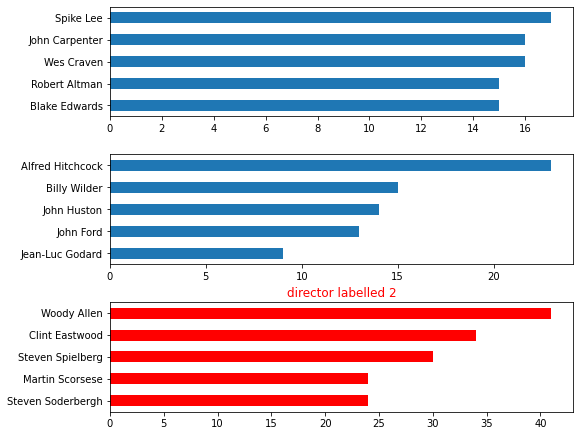

In [18]:
# using subplot function and creating 3 plots
plt.subplot(3, 1, 1)  #count 1
comp0=eda_df[df['director_label_0']==1]
comp0['director_tmdb'].value_counts().head().plot.barh(figsize=(8,6))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
#plt.title('director labelled 0')

plt.subplot(3, 1, 2) #count2
comp1=eda_df[df['director_label_1']==1]
comp1['director_tmdb'].value_counts().head().plot.barh(figsize=(8,6))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
#plt.title('director labelled 1')
 

plt.subplot(3, 1, 3) #count3
comp2=eda_df[df['director_label_2']==1]
comp2['director_tmdb'].value_counts().head().plot.barh(color='r',figsize=(8,6))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.title('director labelled 2',color='r')


# space between the plots
plt.tight_layout(0.5)
 
# show plot
plt.show()

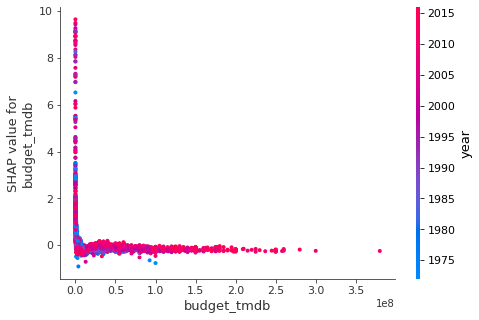

In [19]:
shap.dependence_plot("budget_tmdb", gbr_shap_values, train_X)

This is probably the most surprising result in the global analysis: the budget has a negative impact on the predition of the economic return. This seems to suggest that spending a lot not only does not equate to earning a lot, but also that sometimes the expense can become unprofitable. Another important thing to be spotted is the high impact for the low budget movies. We reckon that, since the low budget movies are considerably less than the high budget ones, SHAP easily discriminates this instances, giving it a great importance to th budget features. We will investigate it in [Test Case 3](#tc3-gbr). 

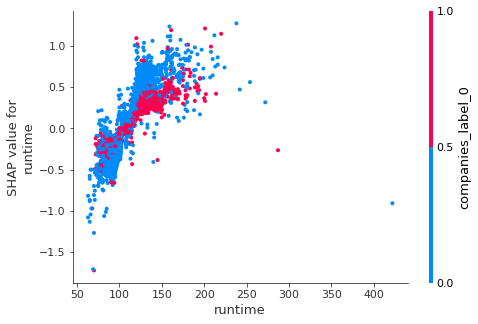

In [20]:
shap.dependence_plot("runtime", gbr_shap_values, train_X)

Not very relevant results for runtime (a slight linear dependence), except for the fact that runtime interacts with 0 companies frequently. Obviously this can be also spot in the previous plot.

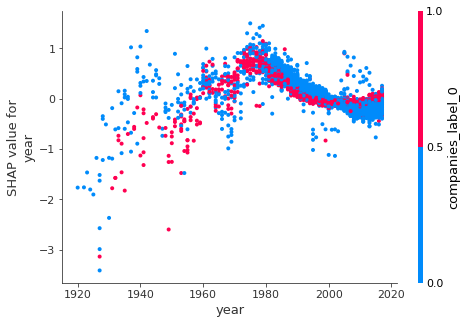

In [21]:
shap.dependence_plot("year", gbr_shap_values, train_X)

Looking at the graph of the years there seems to be a reversal of the trend that coincides with the best years in terms of income for the cinema. In the first part we can spot a liner correlation until 1980 and then an inverse dependecy. This result also appears to be strange. The motivation could be that if on one hand some movies have established record incomes, on the other hand the greater production of films has generated more "trash movies". The success of few hides the failure of many, just as nowadays it could be the richness of a few people that masks the wellness of an entire state. Plots like this shows the importance of always having different points of view.

<a id='li-gbr'></a>
## Local Interpretability ([to top](#top))

This section enables us to pinpoint and contrast the impacts of the factors. Looking at each individual case to  increase the model's transparency.

In [22]:
# Get the predictions and put them with the test data.
output_X = test_X.copy()
output_X.loc[:,'predict'] = np.round(gbr.predict(output_X), 2)
S = output_X.iloc[[200,202,1335],:]
S

,Canada,France,Germany,Hong Kong,Italy,N_spoken_languages,United Kingdom,United States of America,actor_label_0,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_3,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Comedy,is_Drama,is_Horror,is_Mystery,is_Romance,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_2,year,predict
6335,0,0,0,0,0,1,0,1,0,1,0,185000000.0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,1,-8.660254e-01,0.5,0,93.0,0,2012,0.62
7899,0,0,0,1,0,1,0,0,1,0,0,1680000.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,-8.660254e-01,-0.5,0,78.0,0,2009,-1.71
7952,0,0,0,0,0,1,0,0,1,0,0,4000.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,-1.836970e-16,-1.0,1,80.0,0,2008,2.48


<a id='hp-gbr'></a>
### Heatmap plot ([to top](#top))

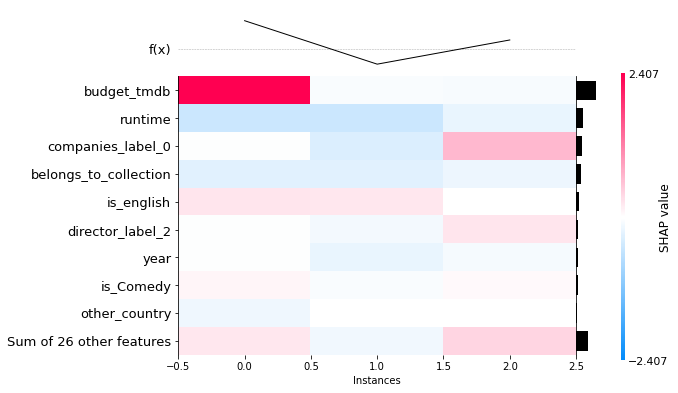

In [23]:
shap_values = gbr_explainer(S)
shap.plots.heatmap(shap_values)

This heatmap is an overview of the magnitude of data in two dimensions. The f(x) curve on the top is the model predictions for the instances. Not being very explanatory, we prefer to focus on single instances.

In [24]:
# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(gbr)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

<a id='tc1-gbr'></a>
### Test Case 1 ([to top](#top))

In [25]:
eda_df.iloc[6335,[11,0,18,6,9,20,1,8]]

title_tmdb                                                           Brave
belongs_to_collection                                                    0
director_tmdb                                               Brenda Chapman
production_companies     ['Walt Disney Pictures', 'Pixar Animation Stud...
runtime                                                                 93
year                                                                  2012
budget_tmdb                                                       1.85e+08
revenue                                                        5.38983e+08
Name: 6335, dtype: object

<a id='isvp-gbr_1'></a>
#### Individual SHAP Value Plot ([to top](#top))

In [26]:
shap.initjs()
print("Base value:", test_y.mean())
print("Target : ", test_y.iloc[200],
      "\nPrediction : ", S['predict'].iloc[0])
shap_plot(0)

Base value: -0.17685156715879227
Target :  1.0693285895011628 
Prediction :  0.62


In this plot the bold value is the prediction for that observation and the base value is the value that would be predicted if we did not know any features for the current output. In other words, it is the mean prediction. This is a compact way to visualize the importance of features. Let's have a look more detailed plots.

<a id='ibp-gbr_1'></a>
#### Individual bar plot ([to top](#top))

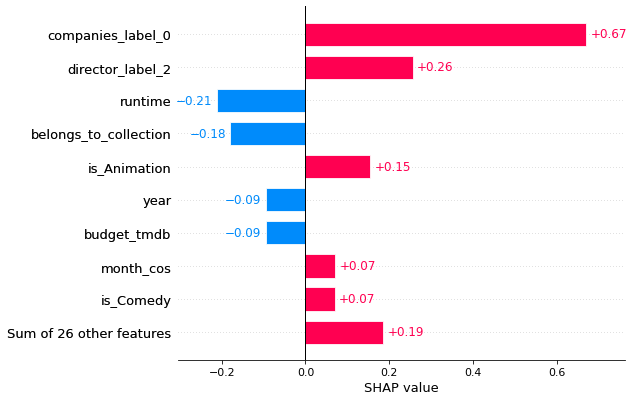

In [27]:
shap.plots.bar(shap_values[0]) # For the first observation

With this plot we can easy spot the contributions of variables. As seen in the global approach, companies 0, year and runtime had a big impact. on the contrary we find variables that had been less important in this regression such as director 2 cluster and is_animation. We can also see that **runtime** and **belongs to collection** had a **positive** impact for the **global** approach, but here the opposite happens.


<a id='wp-gbr_1'></a>
#### Waterfall plot ([to top](#top))

A waterfall plot shows why a case receives its prediction given its variable values. Starting from the bottom the base case is E[f(x)] then add or subtract the values to get to the final prediction.

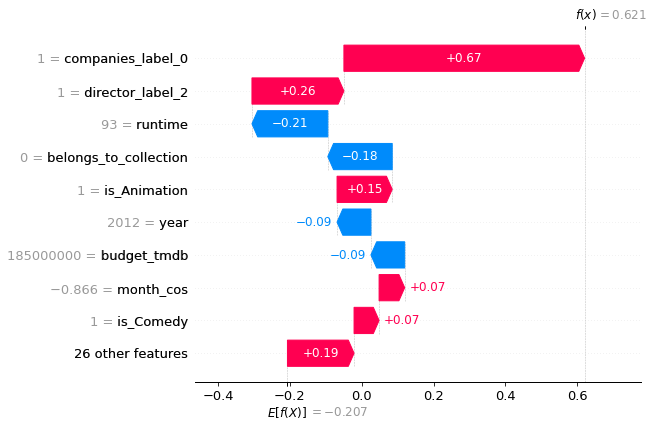

In [28]:
shap.plots._waterfall.waterfall_legacy(shap_values[0].base_values[0], shap_values[0].values, features=shap_values[0].data, feature_names= test_X.columns)

<a id='dp-gbr_1'></a>
#### Decision plot ([to top](#top))

The decision plot shows the same thing as the waterfall one in a more "mathematical" way.

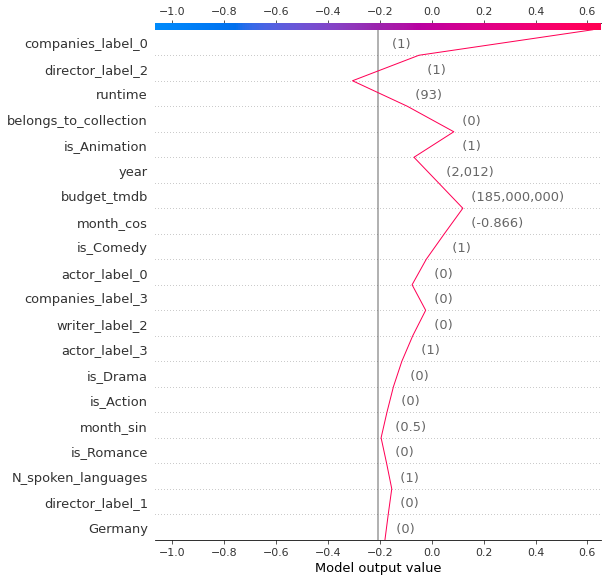

In [29]:
expected_value = gbr_explainer.expected_value
#print("The base value is ", expected_value)
shap_values_0 = gbr_explainer.shap_values(S)[0]
shap.decision_plot(expected_value, shap_values_0, S)

<a id='tc2-gbr'></a>
### Test Case 2 ([to top](#top))

In [30]:
eda_df.iloc[7899,[11,0,18,6,9,20,1,8]]

title_tmdb                          Turning Point
belongs_to_collection                           0
director_tmdb                          Herman Yau
production_companies     ['Shaw Brothers', 'TVB']
runtime                                        78
year                                         2009
budget_tmdb                              1.68e+06
revenue                               2.19894e+06
Name: 7899, dtype: object

<a id='isvp-gbr_2'></a>
#### Individual SHAP Value Plot ([to top](#top))

In [31]:
shap.initjs()
print("Base value:", test_y.mean())
print("Target : ", test_y.iloc[202],
      "\nPrediction : ", S['predict'].iloc[1])
shap_plot(1)

Base value: -0.17685156715879227
Target :  0.2691829969483808 
Prediction :  -1.71


<a id='ibp-gbr_2'></a>
#### Individual bar plot ([to top](#top))

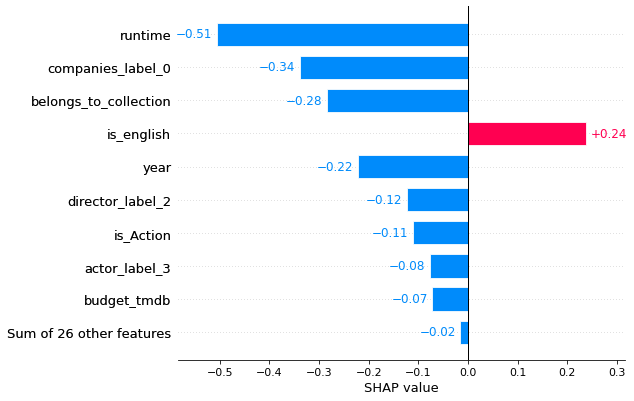

In [32]:
shap.plots.bar(shap_values[1]) # For the second observation

This is certainly the most particular of the cases shown. All major features have a negative impact on prediction. The only positive is "is_english" which is not even in the top 10 of global importance and above all in global it has the opposite impact.

<a id='wp-gbr_2'></a>
#### Waterfall plot ([to top](#top))

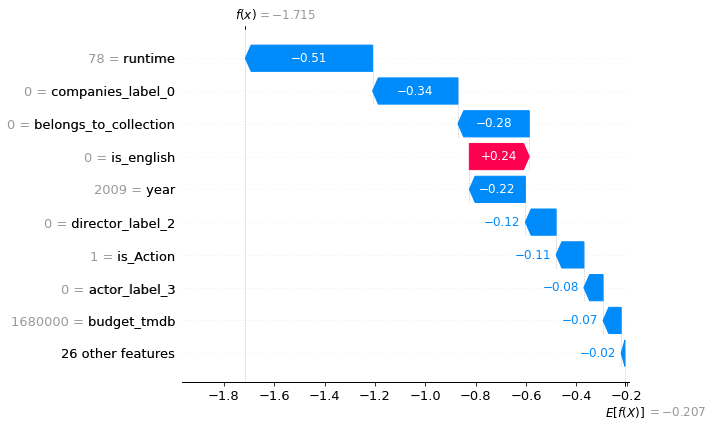

In [33]:
shap.plots._waterfall.waterfall_legacy(shap_values[1].base_values[0], shap_values[1].values, features=shap_values[1].data, feature_names= test_X.columns)

<a id='dp-gbr_2'></a>
#### Decision plot ([to top](#top))

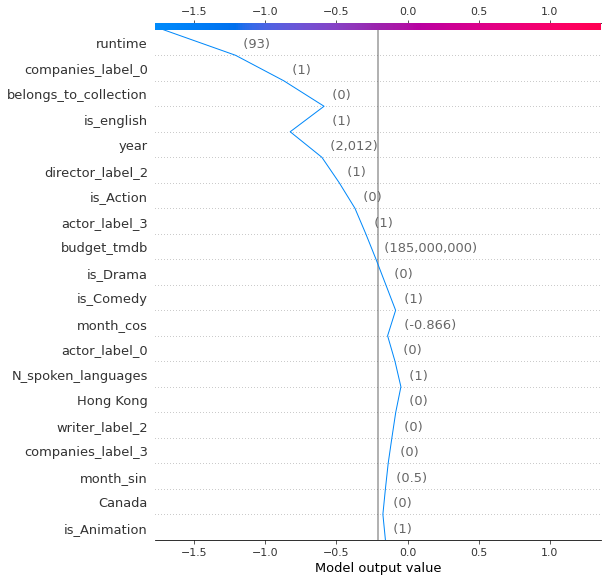

In [34]:
shap_values_2 = gbr_explainer.shap_values(S)[1]
shap.decision_plot(expected_value, shap_values_2, S)

<a id='tc3-gbr'></a>
### Test Case 3 ([to top](#top))

In [35]:
eda_df.iloc[7952,[11,0,18,6,9,20,1,8]]

title_tmdb                                             That's It
belongs_to_collection                                          0
director_tmdb                                      Matheus Souza
production_companies     ['Atitude Produções e Empreendimentos']
runtime                                                       80
year                                                        2008
budget_tmdb                                                 4000
revenue                                                   105933
Name: 7952, dtype: object

<a id='isvp-gbr_3'></a>
#### Individual SHAP Value Plot ([to top](#top))

In [36]:
shap.initjs()
print("Base value:", test_y.mean())
print("Target : ", test_y.iloc[1335],
      "\nPrediction : ", S['predict'].iloc[2])
shap_plot(2)

Base value: -0.17685156715879227
Target :  3.2765124576765623 
Prediction :  2.48


<a id='ibp-gbr_3'></a>
#### Individual bar plot ([to top](#top))

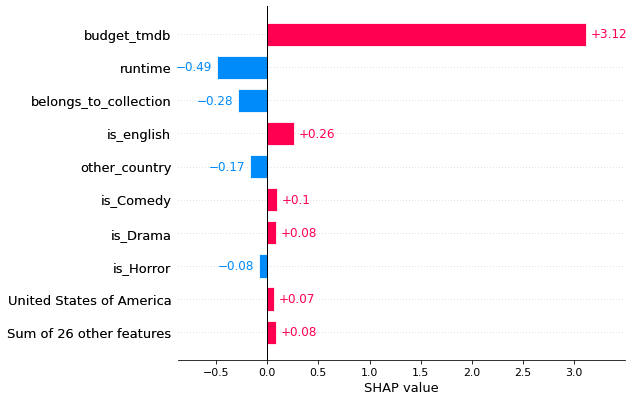

In [37]:
shap.plots.bar(shap_values[2]) 

As we said in [SHAP Dependence Plot](#sdp-gbr) for Budget, our regressor predicts the target for low budget movies, simply "looking at this feature". This implies a surprisingly shap value for the budget_tmdb.

<a id='wp-gbr_3'></a>
#### Waterfall plot ([to top](#top))

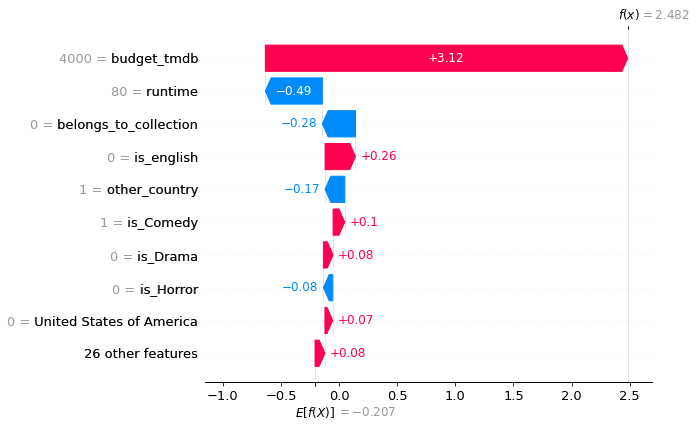

In [38]:
shap.plots._waterfall.waterfall_legacy(shap_values[2].base_values[0], shap_values[2].values, features=shap_values[2].data, feature_names= test_X.columns)

<a id='dp-gbr_3'></a>
#### Decision plot ([to top](#top))

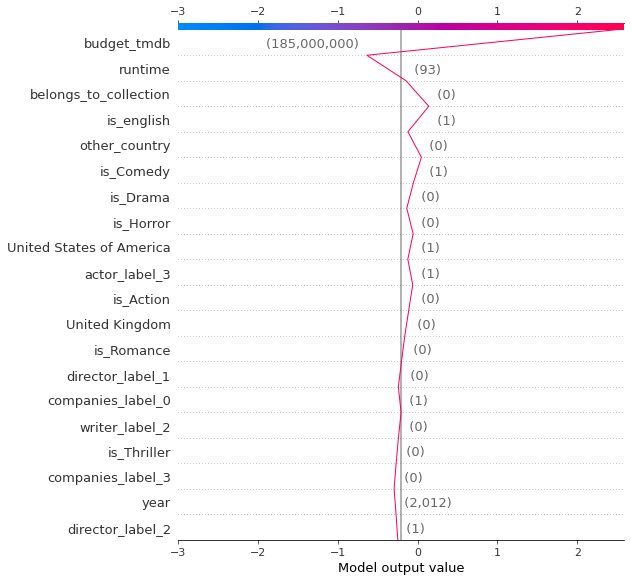

In [39]:
shap_values_3 = gbr_explainer.shap_values(S)[2]
shap.decision_plot(expected_value, shap_values_3, S)

<a id='igm-stc'></a>
# Interpret StackingClassifier model ([to top](#top))

In [40]:
!pip3 install dice-ml

Fix the probelem that SHAP is not compatible with Pipeline

In [41]:
with open('/usr/local/lib/python3.7/dist-packages/shap/explainers/_permutation.py', 'r') as f:
  filedata = f.read()

# Replace the target string
filedata = filedata.replace('return explanation._old_format()', 'return explanation')

# Write the file out again
with open('/usr/local/lib/python3.7/dist-packages/shap/explainers/_permutation.py', 'w') as file:
  file.write(filedata)

In [42]:
# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.base import TransformerMixin, BaseEstimator
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from keras.regularizers import l2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import keras
from numpy.random import seed
seed(1)

# Tensorflow import
import tensorflow as tf
tf.random.set_seed(2)

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

%load_ext autoreload
%autoreload 2

# custom transformer for sklearn pipeline
class LabelTransform(TransformerMixin, BaseEstimator):
    def transform(self, X):
      return X

    def fit(self, X, y=None):
      y= np_utils.to_categorical(y)
      return self

def create_model(init='uniform', optimizer='Adam'):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=len(train_X.columns), kernel_initializer=init, activation='tanh')) 
    model.add(Dropout(0.2))
    model.add(Dense(100, input_dim=len(train_X.columns))) 
    RandomFourierFeatures(
           output_dim=200, kernel_initializer="gaussian"
       ),
    
    model.add(Dense(2, kernel_initializer=init,kernel_regularizer='l2'))
    model.compile(loss=keras.losses.hinge, optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  
    return model

Load the dataset and the Stacking Classifier model we trained in the previous task.

In [43]:
return_df['profitability'] = return_df['return_log'].apply(lambda x: 1 if x >=0 else 0)
X, y = return_df.drop(['revenue', 'return', 'return_log','profitability'], axis=1), return_df['profitability']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

if Path('/content/drive/MyDrive/BDA/models/StackingClassifierPipeline.joblib').is_file():
  stc = load('/content/drive/MyDrive/BDA/models/StackingClassifierPipeline.joblib')
else:
  sc = load('/content/drive/MyDrive/BDA/models/StackingClassifier.joblib')
  stc = Pipeline([
          ('scaler', MinMaxScaler()),
          ('StackingClassifier', sc)
          ])
  stc.fit(train_X, train_y)
  dump(stc, '/content/drive/MyDrive/BDA/models/StackingClassifierPipeline.joblib')
print(stc)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 StackingClassifier(estimators=[('RandomForest',
                                                 RandomForestClassifier(criterion='entropy',
                                                                        min_samples_leaf=2,
                                                                        min_samples_split=9,
                                                                        n_estimators=700,
                                                                        random_state=0)),
                                                ('GradientBossting',
                                                 GradientBoostingClassifier(learning_rate=0.01,
                                                                            max_depth=10,
                                                                            n_estimators=500,
                                                     

In [44]:
test_predictions = stc.predict(test_X)
precision, recall, fscore, _ = precision_recall_fscore_support(test_y,test_predictions,average='macro')
stc_results = {
    "accuracy" : accuracy_score(test_y, test_predictions),
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "roc_auc" : roc_auc_score(test_y,test_predictions)
}
print('Accuracy for testset: %.4f' % stc_results["accuracy"])
print('Precision for testset: %.4f' % stc_results["precision"])
print('Recall for testset: %.4f' % stc_results["recall"])
print('Fscore for testset: %.4f' % stc_results["fscore"])
print('Roc_auc for testset: %.4f' % stc_results["roc_auc"])

Accuracy for testset: 0.7114
Precision for testset: 0.7081
Recall for testset: 0.7083
Fscore for testset: 0.7082
Roc_auc for testset: 0.7083


As we know, it's notoriously difficult to predict which movies will do well at the box office. Maybe that's why so many bombs get made. But it's even tougher to guess which movies will turn a profit, especially early on, when filmmakers are locking down financing from skittich investors. The result shows that the stacking classifier forecasts whether or not a movie will be profitable with an accuracy of over 70%, and this model can be used as a decision support tool for film producers.

<a id='gi-stc'></a>
## Global Interpretability ([to top](#top))

In [45]:
test_X.insert(len(test_X.columns), 'profitability', test_y)
test_X_summary = shap.sample(test_X, len(test_X)//10, random_state=0)
test_dataset_summary = test_X_summary.copy()
test_X = test_X.iloc[:,:-1]
test_X_summary = test_X_summary.iloc[:,:-1]
if Path('/content/drive/MyDrive/BDA/models/stc_shap_values.joblib').is_file():
  stc_shap_values = load('/content/drive/MyDrive/BDA/models/stc_shap_values.joblib')
else: 
  stc_explainer = shap.Explainer(stc.predict, test_X_summary)
  stc_shap_values = stc_explainer.shap_values(test_X_summary)
  dump(stc_shap_values, '/content/drive/MyDrive/BDA/models/stc_shap_values.joblib')

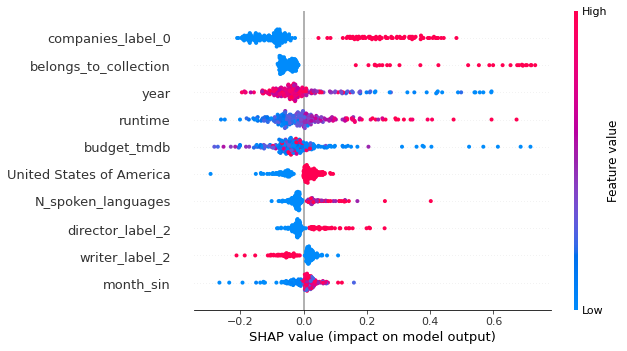

In [46]:
shap.summary_plot(stc_shap_values, test_X_summary, max_display=10)

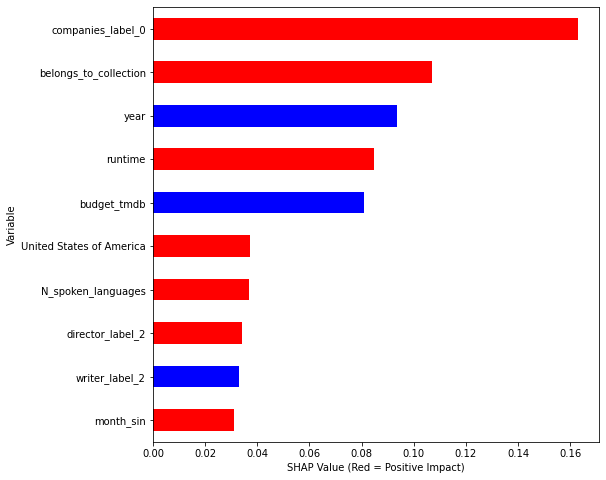

In [47]:
def simple_SHAP(df_shap, df, K):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap.values)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable', how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-K:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,8),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
simple_SHAP(stc_shap_values, test_X_summary, 10)

The top 5 features are the same as our regressor, but with different orders, whereas the companies_label_0 remains the most important one.

Like our regressor, we can see that the *companies_label_0*, *belong_to_collection*, *runtime* tend to push the classifier to 1, while *year*, *budget* push the result to 0.

<a id='li-stc'></a>
## Local Interpretability ([to top](#top))

<a id='tc1-stc'></a>
### Test Case 1 ([to top](#top))

In [48]:
eda_df.iloc[test_dataset_summary.iloc[3].name,[11,0,18,6,9,20,1,8]]

title_tmdb                                           Attack the Block
belongs_to_collection                                               0
director_tmdb                                             Joe Cornish
production_companies     ['UK Film Council', 'Studio Canal', 'Film4']
runtime                                                            88
year                                                             2011
budget_tmdb                                               1.43505e+07
revenue                                                   3.96468e+06
Name: 5972, dtype: object

True_label :  0 
Pred_label :  0


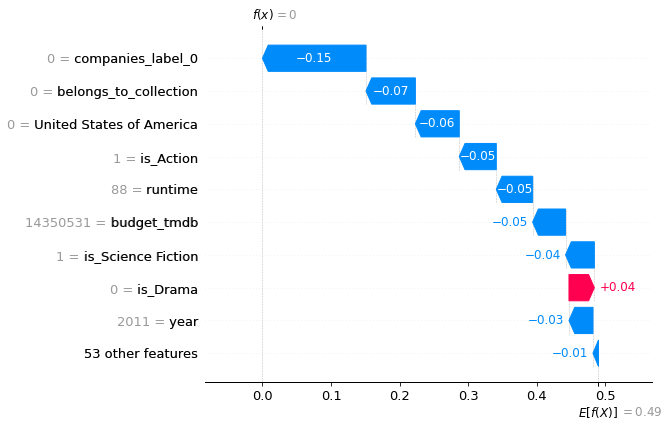

In [49]:
print("True_label : ", int(test_dataset_summary.iloc[3]['profitability']), 
      "\nPred_label : ", stc.predict(test_X_summary)[3])
shap.plots.waterfall(stc_shap_values[3])

Apart from *is_Drama*, most features negatively impact the prediction. This result is understandable since no leading producing companies or directors are involved, and it is not a franchise movie either.

<a id='tc2-stc'></a>
### Test Case 2 ([to top](#top))

In [50]:
eda_df.iloc[test_dataset_summary.iloc[6].name,[11,0,18,6,9,20,1,8]]

title_tmdb                                                  The River Wild
belongs_to_collection                                                    0
director_tmdb                                                Curtis Hanson
production_companies     ['Universal Pictures', 'David Foster Productio...
runtime                                                                111
year                                                                  1994
budget_tmdb                                                        4.5e+07
revenue                                                        9.42163e+07
Name: 230, dtype: object

True_label :  1 
Pred_label :  0


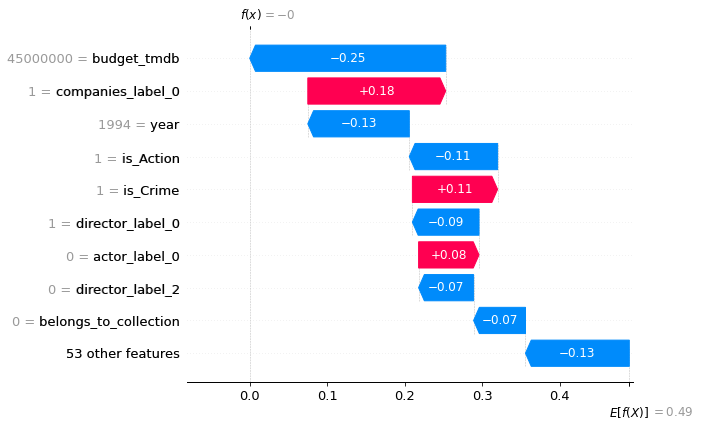

In [51]:
print("True_label : ", int(test_dataset_summary.iloc[6]['profitability']),
      "\nPred_label : ", stc.predict(test_X_summary)[6])
shap.plots.waterfall(stc_shap_values[6])

Although this movie actually grossed more than double its budget, the model believes it would fail as the budget ($45 million) is too high because our model is biased to lower budgets.

<a id='dice-stc'></a>
## Diverse Counterfactual Explanations ([to top](#top))
[Diverse Counterfactual Explanations (DiCE) for ML](https://github.com/interpretml/DiCE)

So far, our explanation methods can provide explanations on why a movie may result in a failure, for example, due to "too high budget," "not good producing companies," "no leading directors," etc. However, these explanations do not help a movie producing company decide what to do next to improve its chance of making a successful movie. 

Critically, the most important features may not be enough to flip the decision of the model, and in practice, may not even be changeable, such as *belong_to_collection* for a new story.

DiCE implements couterfactual(CF) explanations that provide this information by showing a feature-perturbed version of the same company that can make a successful movie, e.g., if they lower the budget by $5 million or cooperate with another leading producing company, or hire a different director.

In other words, it provides "what-if" explanations for model output and can be a useful complement to other explanation methods, both for end-users and model developers.

<a id='tc1-dice-stc'></a>
### Test Case 1 ([to top](#top))

In [52]:
backend = 'TF'+tf.__version__[0] # TF2 in your case
# Step 1: dice_ml.Data
#data = pd.concat([test_X, stc.predict(test_X)], axis=1)
data = test_X.copy()
data.loc[:,'profitability'] = stc.predict(test_X)
d = dice_ml.Data(dataframe=data, continuous_features= ['budget_tmdb', 'N_spoken_languages', 'month_sin', 'month_cos', 'runtime','year'], outcome_name='profitability')
# Pre-trained ML model
m = dice_ml.Model(model=stc, backend='sklearn')
# DiCE explanation instance
exp = dice_ml.Dice(d, m, method="random")

In [53]:
dice_exp = exp.generate_counterfactuals(test_X_summary[3:4], 
                                        total_CFs=3, 
                                        desired_class="opposite", 
                                        random_seed=42, 
                                        verbose=False,
                                        features_to_vary = test_X_summary[test_X_summary.columns.difference(['year', 'month_sin', 'month_cos'])].columns.to_list())
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:03<00:00,  3.62s/it]

Query instance (original outcome : 0)


,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,profitability
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,14350531.0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.5,0.866025,0,88.0,0,0,0,1,2011,0



Diverse Counterfactual set (new outcome: 1.0)


,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,profitability
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,103447403.3,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,128533609.2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,157.2,-,-,-,-,-,1.0


We have generated 3 CFs. This movie would have been successful if 
* The budget increased sixfold and cooperated with leading production companies. 
* The movie belonged to a franchise movie, and the budget increased ninefold. This suggestion is hardly feasible.
* The company hired a director from clustering 0, who is less experienced, and the duration increased to 157.2 minutes.

<a id='tc2-dice-stc'></a>
### Test Case 2 ([to top](#top))

In [54]:
dice_exp = exp.generate_counterfactuals(test_X_summary[6:7], 
                                        total_CFs=3, 
                                        desired_class="opposite", 
                                        random_seed=42, 
                                        verbose=False,
                                        features_to_vary = test_X_summary[test_X_summary.columns.difference(['year', 'month_sin', 'month_cos', 'belongs_to_collection'])].columns.to_list())
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:04<00:00,  4.43s/it]


Query instance (original outcome : 0)


,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,profitability
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,45000000.0,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.5,-0.866025,0,111.0,0,0,1,0,1994,0



Diverse Counterfactual set (new outcome: 1.0)


,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,profitability
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,190.8,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,126538373.9,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,1.0


This movie would have been successful if
* The duration increased to 190.8 minutes. 
* The movie was produced in Russia instead of the United States of America and doubled the budget.
* The movie story is about history instead of crime, and the film was not English.

<a id='arm-stc'></a>
## Association rule mining ([to top](#top))

Up to now, we can see the cluster label, especially **companies_label_0** has a powerful impact on the prediction. In order to understand the knowledge hidden behind the clusters, let's have a look at how the **big-name** of the **production companies**, **actors**, **directors** and **writers** impact the prediction by applying association rule mining.

In [55]:
!pip3 install PyFIM

In [56]:
from fim import apriori
import ast

First, we load the data and extract the name of writers, directors, and actors for each movie with the predicted label and ground truth.

In [57]:
companies_dic = load('/content/drive/MyDrive/BDA/models/companies_dic.joblib')
actor_dic = load('/content/drive/MyDrive/BDA/models/actor_dic.joblib')
director_dic = load('/content/drive/MyDrive/BDA/models/director_dic.joblib')
writer_dic = load('/content/drive/MyDrive/BDA/models/writer_dic.joblib')

In [58]:
eda_df = pd.read_csv('/content/drive/MyDrive/BDA/input/eda_df.csv')
eda_df['writer']= eda_df['writer'].apply(ast.literal_eval).values.tolist()
eda_df['actors_tmdb']= eda_df['actors_tmdb'].apply(ast.literal_eval).values.tolist()
eda_df['production_companies']= eda_df['production_companies'].apply(ast.literal_eval).values.tolist()

actors_list = eda_df['actors_tmdb'].loc[test_X.index.tolist()].apply(lambda x : ['Actor : ' + y for y in x]).values.tolist()
director_list = eda_df['director_tmdb'].loc[test_X.index.tolist()].apply(lambda x : 'Director : ' + x).values.tolist()
writer_list = eda_df['writer'].loc[test_X.index.tolist()].apply(lambda x : ['Writer : ' + y for y in x]).values.tolist()
companies_list = eda_df['production_companies'].loc[test_X.index.tolist()].apply(lambda x : ['production_companies : ' + y for y in x]).values.tolist()
profitability_pred_list = [ 'HIT_pred' if pred ==1 else 'FLOP_pred' for pred in stc.predict(test_X).tolist()]
profitability_label_list = eda_df['return_log'].loc[test_X.index.tolist()].apply(lambda x: 'HIT_label' if x >=0 else 'FLOP_label').values.tolist()
ar_list = [] + actors_list

for i in range(len(test_X)):
  ar_list[i] += writer_list[i]
  ar_list[i] += companies_list[i]
  ar_list[i].extend((director_list[i], profitability_label_list[i], profitability_pred_list[i]))
print(ar_list[0])

['Actor : Sterling Hayden', 'Actor : Louis Calhern', 'Actor : Jean Hagen', 'Writer : Ben Maddow', 'Writer : John Huston', 'production_companies : Metro-Goldwyn-Mayer (MGM)', 'Director : John Huston', 'FLOP_label', 'HIT_pred']


Then, we run the apriori algorithm from PyFIM with different lengths of itemset and support. The rules with "HIT" or "FLOP" as their consequents together with their lift and confidence will be reported.

<a id='tr-stc'></a>
### Top rules ([to top](#top))


Let's look at the rules detected from the test dataset, augmented with profitability predicted by the stacking classifier.

In [59]:
rules = apriori(ar_list, supp=0.4, zmin=3, target='r', conf=90, report='lc')
for r in rules:
  if r[0]=='HIT_pred':
    print(r)

('HIT_pred', ('Director : Alfred Hitchcock', 'HIT_label'), 1.8147540983606558, 1.0)
('HIT_pred', ('production_companies : Malpaso Productions', 'HIT_label'), 1.8147540983606558, 1.0)
('HIT_pred', ('Director : Clint Eastwood', 'HIT_label'), 1.8147540983606558, 1.0)
('HIT_pred', ('Actor : Woody Allen', 'Director : Woody Allen', 'Writer : Woody Allen'), 1.8147540983606558, 1.0)
('HIT_pred', ('Actor : Woody Allen', 'Director : Woody Allen'), 1.8147540983606558, 1.0)
('HIT_pred', ('Actor : Woody Allen', 'Writer : Woody Allen'), 1.8147540983606558, 1.0)
('HIT_pred', ('production_companies : Legendary Pictures', 'HIT_label'), 1.8147540983606558, 1.0)
('HIT_pred', ('Director : Woody Allen', 'Writer : Woody Allen', 'HIT_label'), 1.8147540983606558, 1.0)
('HIT_pred', ('Director : Woody Allen', 'Writer : Woody Allen'), 1.6851288056206088, 0.9285714285714286)
('HIT_pred', ('Director : Woody Allen', 'HIT_label'), 1.8147540983606558, 1.0)
('HIT_pred', ('Writer : Woody Allen', 'HIT_label'), 1.8147540

Then we also mined the rules from the test dataset with ground truth.

In [60]:
rules = apriori(ar_list, supp=0.4, zmin=3, target='r', conf=90, report='lc')
for r in rules:
  if r[0]=='HIT_label':
    print(r)

('HIT_label', ('Director : Alfred Hitchcock', 'HIT_pred'), 1.8073469387755101, 1.0)
('HIT_label', ('production_companies : Malpaso Productions', 'HIT_pred'), 1.8073469387755101, 1.0)
('HIT_label', ('Director : Clint Eastwood', 'HIT_pred'), 1.6266122448979592, 0.9)
('HIT_label', ('production_companies : Legendary Pictures', 'HIT_pred'), 1.6430426716141002, 0.9090909090909091)
('HIT_label', ('Actor : John Travolta', 'HIT_pred'), 1.6430426716141002, 0.9090909090909091)
('HIT_label', ('Actor : Morgan Freeman', 'HIT_pred'), 1.8073469387755101, 1.0)
('HIT_label', ('Actor : Tom Hanks', 'HIT_pred'), 1.6782507288629738, 0.9285714285714286)
('HIT_label', ('production_companies : Relativity Media', 'HIT_pred'), 1.7069387755102041, 0.9444444444444444)
('HIT_label', ('production_companies : Lionsgate', 'HIT_pred'), 1.8073469387755101, 1.0)
('HIT_label', ('production_companies : Fox Searchlight Pictures', 'HIT_pred'), 1.6266122448979592, 0.9)


We can see that "Director : **Alfred Hitchcock**", "production_companies : **Malpaso Productions**" , "Director : **Clint Eastwood**", "production_companies : **Legendary Pictures**", Actor : **John Travolta**", "Actor : **Morgan Freeman**" and "production_companies : **Relativity Media**" are th **KEY** to the **HIT** both for the two sets of rules.

So what about the **different rules** shown above?

Some additional rules are found from the customized dataset but not present in the original dataset.  

 For example,  if  **Woody Allen**  acted as an actor in a movie directed by himself, the model thinks it is a HIT, even though it is not. 

Furthermore, the models tend to say movies produced by big production companies will be a HIT, such as **Twentieth Century Fox Film Corporation**, **Paramount Pictures**, **Warner Bros.**, **Universal Pictures**.  It is mainly because these companies belong to the cluster "companies_label_0," which has the most powerful impact on the prediction observed from the previous SHAP explanation.

<a id='rrtcp-stc'></a>
### Rules related to correct and incorrect prediction ([to top](#top))

In [61]:
# Correct = TP + TN
rules = apriori(ar_list, supp=0.5, zmin=3, target='r', conf=100, report='l')
for r in rules:
  if (r[0]=='HIT_pred' and 'HIT_label' in r[1]) or (r[0]=='FLOP_pred' and 'FLOP_label' in r[1]):
    print(r)

('HIT_pred', ('production_companies : Imagine Entertainment', 'HIT_label'), 1.8147540983606558)
('HIT_pred', ('production_companies : Summit Entertainment', 'HIT_label'), 1.8147540983606558)
('HIT_pred', ('production_companies : DreamWorks SKG', 'HIT_label'), 1.8147540983606558)
('HIT_pred', ('production_companies : Village Roadshow Pictures', 'HIT_label'), 1.8147540983606558)


In [62]:
print('Imagine Entertainment companies_label :', companies_dic['K-Means_Labels']['Imagine Entertainment'])
print('Summit Entertainment companies_label :', companies_dic['K-Means_Labels']['Summit Entertainment'])
print('DreamWorks SKG companies_label :',companies_dic['K-Means_Labels']['DreamWorks SKG'])

Imagine Entertainment companies_label : 0
Summit Entertainment companies_label : 0
DreamWorks SKG companies_label : 0


Very interesting, the top 3 rules related to correct prediction all take **companies_label_0** into account.

Do rules with **companies_label_0** always give a correct prediction?

In [63]:
# Incorrect = FP + FN
rules = apriori(ar_list, supp=0.2, zmin=3, target='r', conf=100, report='l')
for r in rules:
  if (r[0]=='HIT_pred' and 'FLOP_label' in r[1]) or (r[0]=='FLOP_pred' and 'HIT_label' in r[1]):
    print(r)

('HIT_pred', ('Actor : John Turturro', 'FLOP_label'), 1.8147540983606558)
('HIT_pred', ('production_companies : NPV Entertainment', 'production_companies : Village Roadshow Pictures', 'FLOP_label'), 1.8147540983606558)
('HIT_pred', ('production_companies : NPV Entertainment', 'FLOP_label'), 1.8147540983606558)
('FLOP_pred', ('production_companies : Hollywood Pictures', 'HIT_label'), 2.227364185110664)
('HIT_pred', ('production_companies : Summit Entertainment', 'FLOP_label'), 1.8147540983606558)


In [64]:
print('Pedro Almodóvar director _label :', director_dic['K-Means_Labels']['Pedro Almodóvar'])
print('Pedro Almodóvar writer_label:', writer_dic['K-Means_Labels']['Pedro Almodóvar'])
print('NPV Entertainment companies_label :', companies_dic['K-Means_Labels']['NPV Entertainment'])
print('Village Roadshow Pictures companies_label :', companies_dic['K-Means_Labels']['Village Roadshow Pictures'])
print('Hollywood Pictures companies_label :', companies_dic['K-Means_Labels']['Hollywood Pictures'])

Pedro Almodóvar director _label : 0
Pedro Almodóvar writer_label: 0
NPV Entertainment companies_label : 0
Village Roadshow Pictures companies_label : 0
Hollywood Pictures companies_label : 3


The answer is no.

<a id='rrttc-stc'></a>
### Rules related to the cooperation ([to top](#top))

 Rules related to the cooperation between actors, writers,  directors and production companies.

In [65]:
# Correct = TP + TN
rules = apriori(ar_list, supp=0.1, zmin=6, target='r', conf=100, report='l')
for r in rules:
  if (r[0]=='HIT_pred' and 'HIT_label' in r[1]) or (r[0]=='FLOP_pred' and 'FLOP_label' in r[1]):
    print(r)

('HIT_pred', ('Writer : Marcus Dunstan', 'Writer : Patrick Melton', 'Actor : Costas Mandylor', 'Actor : Tobin Bell', 'production_companies : Twisted Pictures', 'HIT_label'), 1.8147540983606558)
('HIT_pred', ('Writer : Marcus Dunstan', 'Writer : Patrick Melton', 'Actor : Costas Mandylor', 'Actor : Tobin Bell', 'HIT_label'), 1.8147540983606558)
('HIT_pred', ('Writer : Marcus Dunstan', 'Writer : Patrick Melton', 'Actor : Costas Mandylor', 'production_companies : Twisted Pictures', 'HIT_label'), 1.8147540983606558)
('HIT_pred', ('Writer : Marcus Dunstan', 'Writer : Patrick Melton', 'Actor : Tobin Bell', 'production_companies : Twisted Pictures', 'HIT_label'), 1.8147540983606558)
('HIT_pred', ('Writer : Marcus Dunstan', 'Actor : Costas Mandylor', 'Actor : Tobin Bell', 'production_companies : Twisted Pictures', 'HIT_label'), 1.8147540983606558)
('HIT_pred', ('Writer : Patrick Melton', 'Actor : Costas Mandylor', 'Actor : Tobin Bell', 'production_companies : Twisted Pictures', 'HIT_label'), 1.

**Saw** is an American horror franchise produced by **Twisted Pictures**. It consists of nine feature films and additional media. **Tobin Bell** and **Costas Mandylor** are the central actors of the series. **Patrick Melton** acted as a screenwriter for Saw IV/V/VI/3D.

**Resident Evil** is an action-horror film series based on the Japanese video game franchise of the same name by Capcom. **Ali Larter** and **Milla Jovovich** are the central actors of series. **Paul W.S. Anderson** acted as a screenwriter, director and producer for most of the series. 

**Woody Allen** : is an American film director, writer, actor, and comedian whose career spans more than six decades and multiple Academy Award-winning films. He has a lot of 
self-written, directed and acted movies.
The question is did all these kinds of movies were **HIT** as the model predicted?

In [66]:
print(len(eda_df[eda_df['director_tmdb']=='Woody Allen']))
eda_df[eda_df['director_tmdb']=='Woody Allen'][['title_tmdb','actors_tmdb','writer','director_tmdb']].tail(10)

41


,title_tmdb,actors_tmdb,writer,director_tmdb
4425,Scoop,"[Scarlett Johansson, Hugh Jackman, Woody Allen]",[Woody Allen],Woody Allen
5045,Vicky Cristina Barcelona,"[Scarlett Johansson, Rebecca Hall, Javier Bardem]",[Woody Allen],Woody Allen
5293,Whatever Works,"[Larry David, Evan Rachel Wood, Adam Brooks]",[Woody Allen],Woody Allen
5752,You Will Meet a Tall Dark Stranger,"[Gemma Jones, Anthony Hopkins, Naomi Watts]",[Woody Allen],Woody Allen
5959,Midnight in Paris,"[Owen Wilson, Rachel McAdams, Kurt Fuller]",[Woody Allen],Woody Allen
6338,To Rome with Love,"[Woody Allen, Roberto Benigni, Penélope Cruz]",[Woody Allen],Woody Allen
6697,Blue Jasmine,"[Cate Blanchett, Alec Baldwin, Sally Hawkins]",[Woody Allen],Woody Allen
7072,Magic in the Moonlight,"[Colin Firth, Emma Stone, Hamish Linklater]",[Woody Allen],Woody Allen
7753,Irrational Man,"[Joaquin Phoenix, Emma Stone, Jamie Blackley]",[Woody Allen],Woody Allen
8265,Café Society,"[Jesse Eisenberg, Kristen Stewart, Blake Lively]",[Woody Allen],Woody Allen


In [67]:
# Incorrect = FP + FN
rules = apriori(ar_list, supp=0.1, zmin=5, target='r', conf=100, report='l')
for r in rules:
  if (r[0]=='HIT_pred' and 'FLOP_label' in r[1]) or (r[0]=='FLOP_pred' and 'HIT_label' in r[1]):
    print(r)

('HIT_pred', ('Actor : Woody Allen', 'Writer : Woody Allen', 'Director : Woody Allen', 'FLOP_label'), 1.8147540983606558)


The answer is not. As successful as Woody Allen, there are still movies resulting in a FLOP.

<a id='conc-ar'></a>
### Conclusion ([to top](#top))

From the above, we can see that the cooperation between **famous** **directors**/**writers**/**actors** and **companies** usually leads to a **HIT**, but some exceptions exist. 


In addition, we also can deduce that the **franchise movies** and the movies produced by the **leading production company** tend to be **HIT**, which explained their top spot in feature importance.

<a id='conc'></a>
# Conclusion ([to top](#top))

In this notebook:
1. We adopted the model implementation **recommendation** to **drop** the features ('**popularity**', '**vote_average**', '**vote_count**') that are still not available before a movie is released. After the models got retained, we **compared the performance** of post-prediction and pre-prediction for both **regression** and **classification** tasks.

2. We tried different approaches such as **permutation importance**, **SHAP**, **diverse counterfactual**, and **association rules** to interpret the best model (**GradientBoostingRegressor**, **StackingClassifier**) in **regression** and **classification** tasks. The explanation shows that the **leading production company** has the most **powerful impact** and **positive impact** on the pre-prediction. The feature "**belongs_to_collection**" also contributes a lot for making a positive pre-prediction, which shows the **franchise movies** tend to be **HIT**. On the other hand, very surprising, the **budget** feature **negatively impacts** the pre-prediction, which indicates that **low-budget** films are more accessible to **make a profit** than those with a high budget.


In [69]:
!pip install jovian --upgrade --quiet
import jovian
# Execute this to save new versions of the notebook
jovian.commit(project="model-interpretation-and-explanation")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/lilanpei/model-interpretation-and-explanation


'https://jovian.ai/lilanpei/model-interpretation-and-explanation'